In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
plt.rcParams["figure.dpi"] = 100

from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.statespace.tools import diff 

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

## Section 1: Data Exploration and Pre-Processing

In [2]:
df = pd.read_csv('usd-pkr.csv')
df.head()

Date   Price    Open    High     Low Change %
0   2/5/1992  24.802  24.802  24.802  24.802    0.00%
1   2/6/1992  24.802  24.802  24.802  24.802    0.00%
2   2/7/1992  24.802  24.802  24.802  24.802    0.00%
3  2/10/1992  24.802  24.802  24.802  24.802    0.00%
4  2/11/1992  24.802  24.802  24.802  24.802    0.00%

In [3]:
print ("Rows : ", df.shape[0])
print ("Columns : ", df.shape[1])
print ("\nFeatures : \n", df.columns.tolist())

Rows :  8162
Columns :  6

Features : 
 ['Date', 'Price', 'Open', 'High', 'Low', 'Change %']


### Missing Values

In [4]:
print ("\nMissing values : ", df.isnull().any())
print ("\nUnique values : \n", df.nunique())


Missing values :  Date        False
Price       False
Open        False
High        False
Low         False
Change %    False
dtype: bool

Unique values : 
 Date        8162
Price       2474
Open        2459
High        3194
Low         2453
Change %     336
dtype: int64


### Removing Columns

In [5]:
df1 = df[['Date', 'Price']]
df1.head()

Date   Price
0   2/5/1992  24.802
1   2/6/1992  24.802
2   2/7/1992  24.802
3  2/10/1992  24.802
4  2/11/1992  24.802

In [6]:
df1.dtypes

Date      object
Price    float64
dtype: object

### Changing Date type to 'Datetime'

In [7]:
df1['Date'] =  pd.to_datetime(df1['Date'])
df1.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

### Sorting by Monthly Averages

In [8]:
monthly_data = df1.resample('MS', on='Date').mean().reset_index().sort_values(by='Date')

### Setting Date as Index

In [9]:
monthly_data = monthly_data.set_index('Date')
monthly_data.head()

Price
Date                 
1992-02-01  24.802000
1992-03-01  24.907000
1992-04-01  25.077455
1992-05-01  25.158238
1992-06-01  25.184818

### Some Basic Statistics

In [10]:
monthly_data.describe()

Price
count  351.000000
mean    74.551168
std     35.548875
min     24.802000
25%     51.872167
50%     60.752045
75%    100.319573
max    167.528571

## Visualizing Time Series

### _Range Slider Graph_

In [11]:
mpl.rcParams['figure.figsize'] = (9,8)
mpl.rcParams['axes.grid'] = False

fig = px.line(monthly_data.reset_index(), x='Date', y='Price', title='PKR-USD Exchange Rate')

fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(count=2, label='5y', step='year', stepmode='backward'),
                dict(count=3, label='10y', step='year', stepmode='backward'),
                dict(count=4, label='15y', step='year', stepmode='backward'),
                dict(count=5, label='20y', step='year', stepmode='backward'),
                dict(step='all')])))
fig.show()

### _Box Plot_

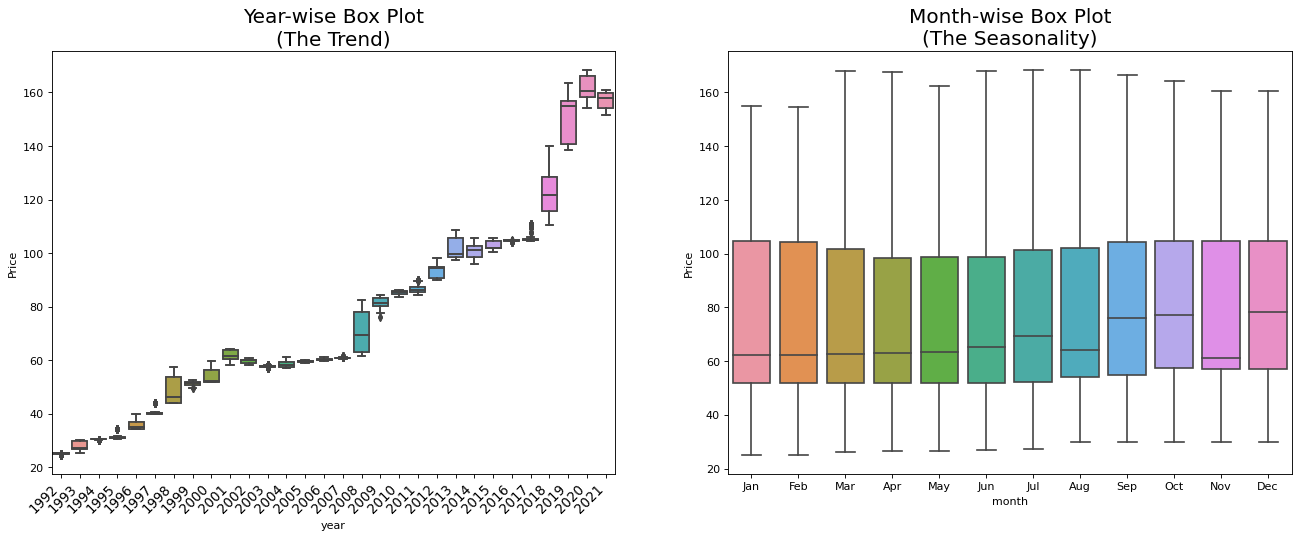

In [12]:
dff = df1.copy()
dff['year'] = [d.year for d in dff.Date]
dff['month'] = [d.strftime('%b') for d in dff.Date]
years = dff['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=dff, ax=axes[0])
sns.boxplot(x='month', y='Price', data=dff.loc[~dff.year.isin([1992, 2021]), :])
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[0].set_xticklabels(
    sns.boxplot(x='year', y='Price', data=dff, ax=axes[0]).get_xticklabels(), rotation=45, horizontalalignment='right',
    fontweight='light',fontsize=12)
plt.show()

### _Lagged Values Plot_

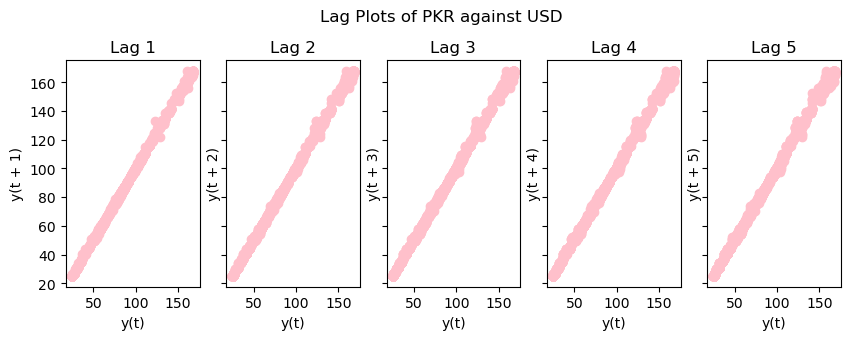

In [13]:
df2 = df.drop(columns=['Open','High','Low','Change %'])
fig, axes = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(df2.Price, lag=i+1, ax=ax, c='pink')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of PKR against USD', y=1.05)    
plt.show()

# Section 2: Seasonal Decomposition

## a) Additive Decomposition

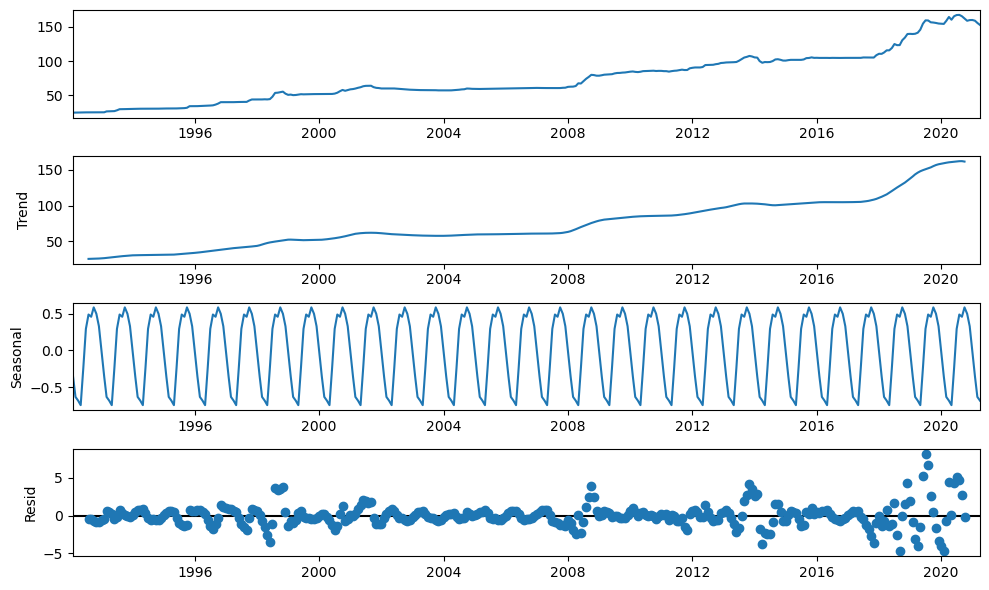

In [14]:
mpl.rcParams['figure.figsize'] = (10,6)
decomposition = seasonal_decompose(monthly_data, model='additive')   
fig = decomposition.plot()
plt.show()

## b) STL Decomposition

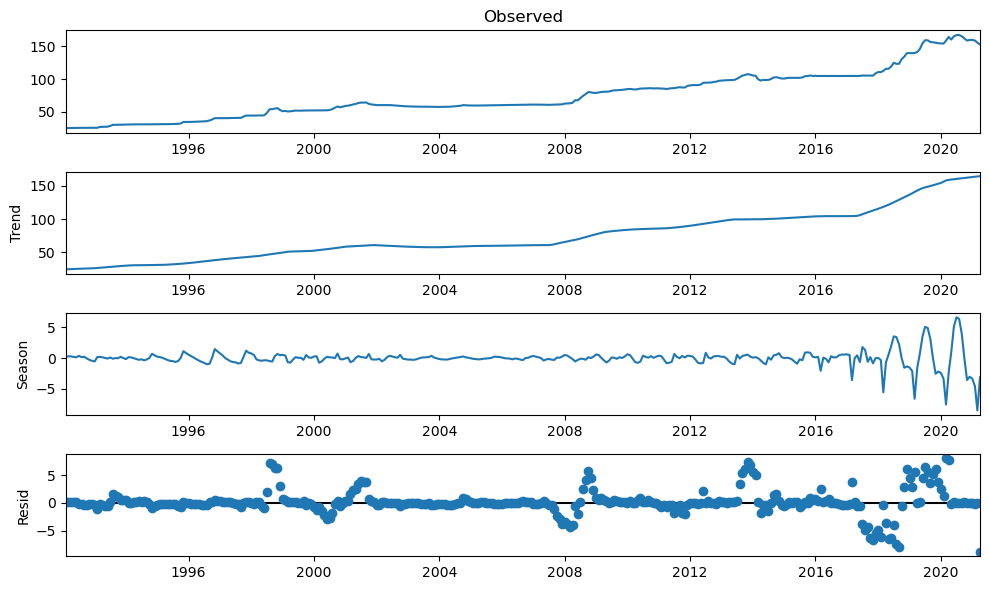

In [15]:
# Seasonal and Trend decomposition using Loess to estimate nonlinear relationships
# set robust to True to handle outliers
res = STL(monthly_data, robust = True).fit() 
fig = res.plot()
plt.show()

# _HP Filter to separate Trend and Cycle_

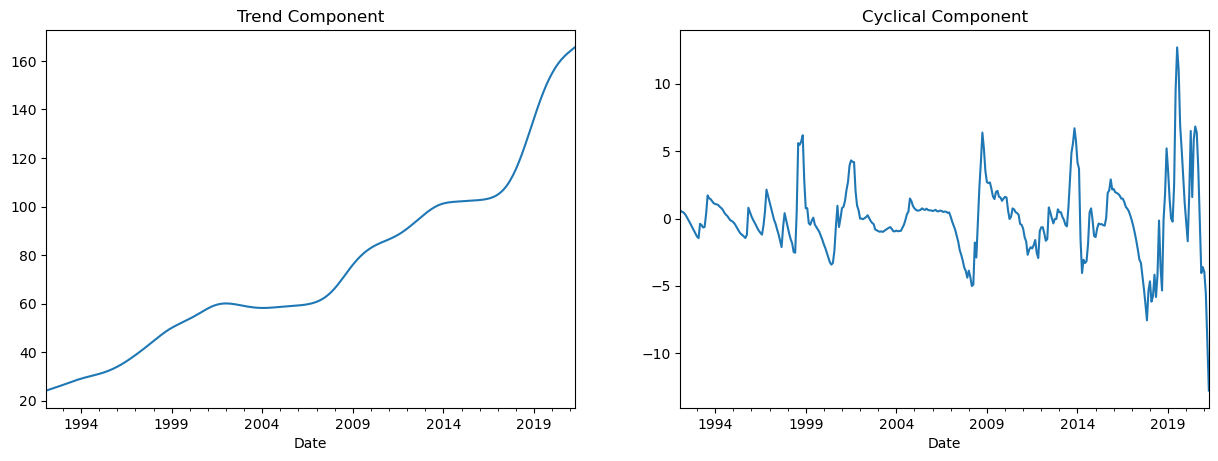

In [16]:
remaining, trend = hpfilter(monthly_data, lamb=1600*3^4) 
# for Monthly Data lambda is 129,600

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
trend.plot(ax=axes[0], title='Trend Component');
remaining.plot(ax=axes[1], title='Cyclical Component');

# Section 3: Stationarity

## _Augmented Dickey Fuller Test_

In [17]:
print('Results of ADF Test:\n')                
dftest = adfuller(monthly_data['Price'])               
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
for key,value in dftest[4].items():                        
    dfoutput['Critical Value (%s)' %key] = value
dfoutput

Results of ADF Test:



Test Statistic                  -0.071118
p-value                          0.952240
No. of Lags used                 8.000000
Number of observations used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64

##### The time series is not stationary since p-value > 0.05

## Stationarizing Time Series:

### a) Log of Price

Text(0.5, 1.0, 'Log of Price')

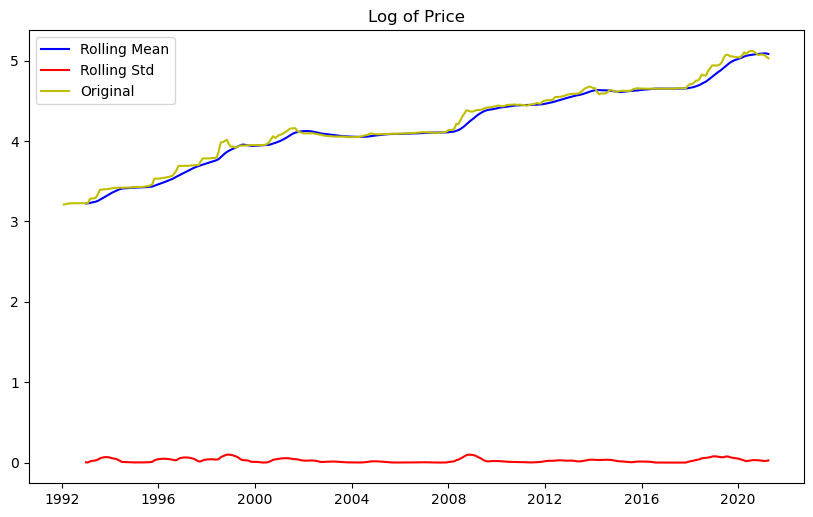

In [18]:
monthly_data['log_Price'] = np.log(monthly_data['Price'])
log_Price = monthly_data['log_Price']

plt.plot(monthly_data['log_Price'].rolling(window=12).mean(), 'b', label='Rolling Mean')
plt.plot(monthly_data['log_Price'].rolling(window=12).std(), 'r', label='Rolling Std')
plt.plot(monthly_data['log_Price'], 'y', label='Original')
plt.legend()
plt.title('Log of Price')

#### _ADF Test on log of Price column_

In [19]:
print('Results of ADF Test:\n')                
test = adfuller(monthly_data['log_Price'])               
output = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
for key,value in test[4].items():                        
    output['Critical Value (%s)' %key] = value
output

Results of ADF Test:



Test Statistic                  -1.192542
p-value                          0.676796
No. of Lags used                 4.000000
Number of observations used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64

##### The time series is still not stationary since p-value > 0.05  

### b) Differencing

### _Price_

Text(0.5, 1.0, 'Price (1st difference)')

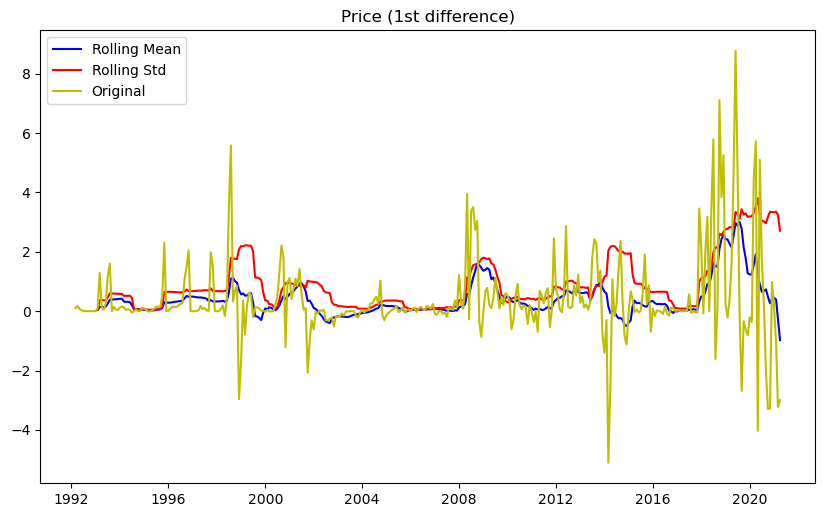

In [20]:
first_Price_difference = diff(monthly_data['Price'], k_diff=1)    # k_diff -- number of times you want to difference series
monthly_data['first_Price_difference'] = first_Price_difference    # use this k_diff value as d component in ARIMA

plt.plot(monthly_data['first_Price_difference'].rolling(window=12).mean(), 'b', label='Rolling Mean')
plt.plot(monthly_data['first_Price_difference'].rolling(window=12).std(), 'r', label='Rolling Std')
plt.plot(monthly_data['first_Price_difference'], 'y', label='Original')
plt.legend()
plt.title('Price (1st difference)')

#### _ADF Test on first difference of Price column_

In [21]:
print('Results of ADF Test:\n')                
test = adfuller(first_Price_difference)               
output = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
for key,value in test[4].items():                        
    output['Critical Value (%s)' %key] = value
output

Results of ADF Test:



Test Statistic                  -4.538279
p-value                          0.000168
No. of Lags used                 7.000000
Number of observations used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64

##### p-value < 0.05 so time series is now stationary 

### _Log of Price_

Text(0.5, 1.0, 'Log of Price (1st difference)')

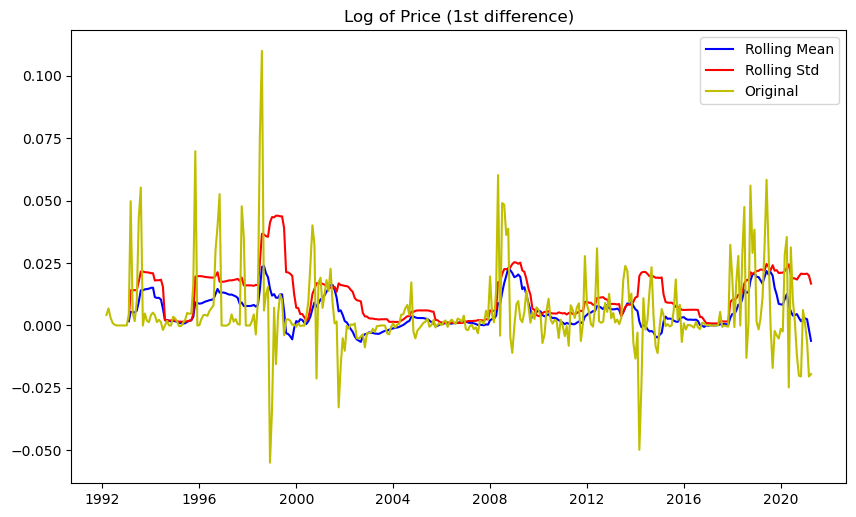

In [22]:
first_log_difference = diff(monthly_data['log_Price'], k_diff=1)    
monthly_data['first_log_difference'] = first_log_difference         

plt.plot(monthly_data['first_log_difference'].rolling(window=12).mean(), 'b', label='Rolling Mean')
plt.plot(monthly_data['first_log_difference'].rolling(window=12).std(), 'r', label='Rolling Std')
plt.plot(monthly_data['first_log_difference'], 'y', label='Original')
plt.legend()
plt.title('Log of Price (1st difference)')

#### _ADF Test on first differenced log of Price column_

In [23]:
print('ADF Test Result:\n')                 
test = adfuller(first_log_difference.dropna())
output = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
for key,value in test[4].items():                        
    output['Critical Value (%s)' %key] = value
output

ADF Test Result:



Test Statistic                -8.525710e+00
p-value                        1.070634e-13
No. of Lags used               3.000000e+00
Number of observations used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64

##### time series is even more stationary since p-value is very significantly less than 0.05

## _Comparing Stationarizing Methods_

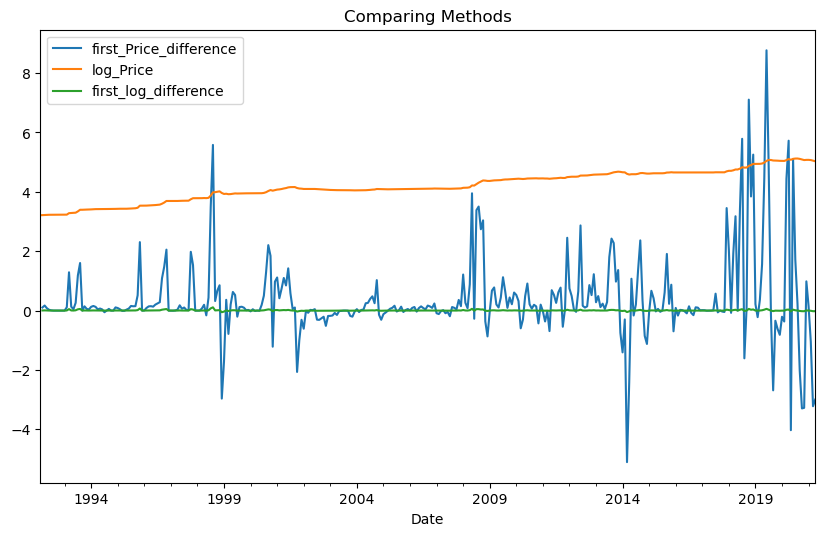

In [24]:
monthly_data[['first_Price_difference','log_Price','first_log_difference']].plot(title=('Comparing Methods'))

# Section 4: Smoothing Based Methods

## _Holt Winters Exponential Smoothing (HWES)_

In [25]:
monthly_data.index.freq = 'MS'
m = 12
alpha = 1/(2*m)

### a) Single Exponential Smoothing

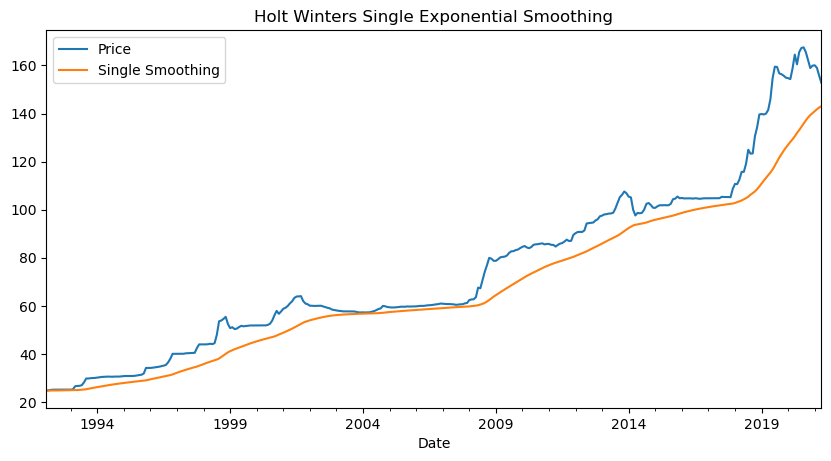

In [26]:
monthly_data['Single Smoothing'] = SimpleExpSmoothing(monthly_data['Price']).fit(smoothing_level=alpha,
                                                                          optimized=False,use_brute=True).fittedvalues
monthly_data[['Price','Single Smoothing']].plot(title='Holt Winters Single Exponential Smoothing', figsize=(10,5))

##### doesn't fit well because single exponential smoothing doesn’t work for data with trends and seasonality

### b) Double Exponential Smoothing

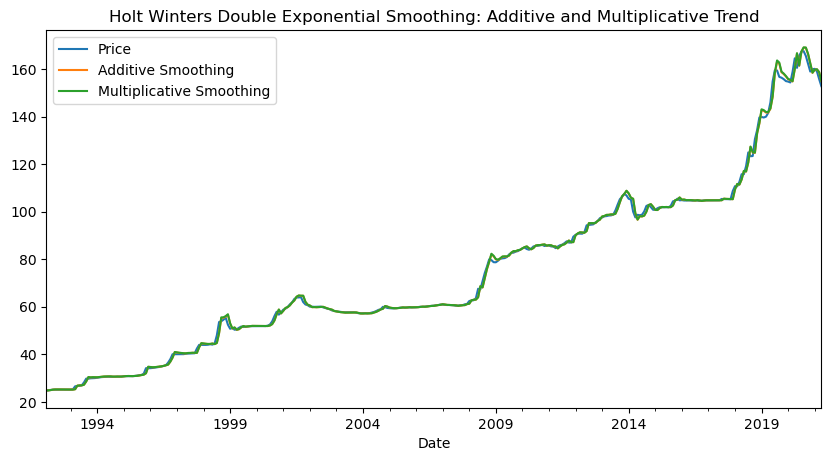

In [27]:
monthly_data['Additive Smoothing'] = ExponentialSmoothing(monthly_data['Price'],trend='add').fit().fittedvalues
monthly_data['Multiplicative Smoothing'] = ExponentialSmoothing(monthly_data['Price'],trend='mul').fit().fittedvalues
monthly_data[['Price','Additive Smoothing','Multiplicative Smoothing']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend', figsize=(10,5))

##### better, still checking triple exponential smoothing method because there is some seasonality in the data

### c) Triple Exponential Smoothing

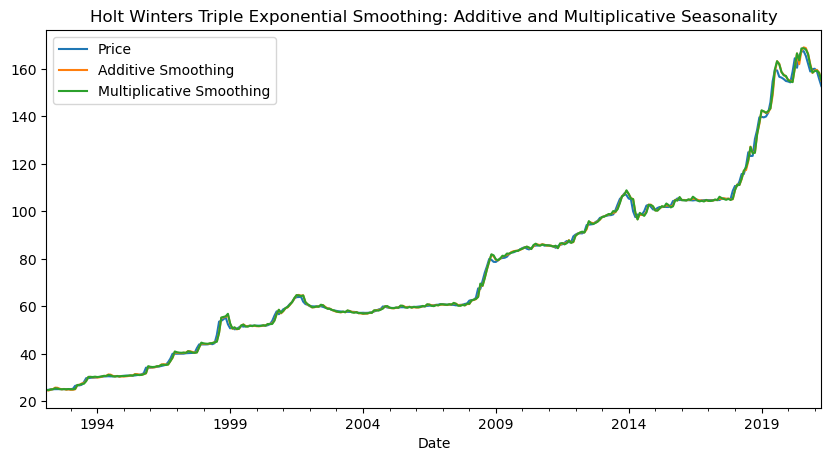

In [28]:
monthly_data['Additive Smoothing'] = ExponentialSmoothing(monthly_data['Price'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
monthly_data['Multiplicative Smoothing'] = ExponentialSmoothing(monthly_data['Price'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
monthly_data[['Price','Additive Smoothing','Multiplicative Smoothing']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality', figsize=(10,5))

##### there is no significant difference in triple exponential smoothing 

## Forecasting by Exponential Smoothing

In [29]:
monthly_data1 = monthly_data[['Price']] # used price

train_data1 = monthly_data1[:301]
test_data1 = monthly_data1[301:]

In [30]:
test_data1.head()

Price
Date                  
2017-03-01  104.791129
2017-04-01  104.789000
2017-05-01  104.790000
2017-06-01  104.802667
2017-07-01  105.372258

In [31]:
test_data1.tail()

Price
Date                  
2020-12-01  159.927273
2021-01-01  160.076190
2021-02-01  159.026667
2021-03-01  155.805217
2021-04-01  152.807381

### _Double Exponential Smoothing_

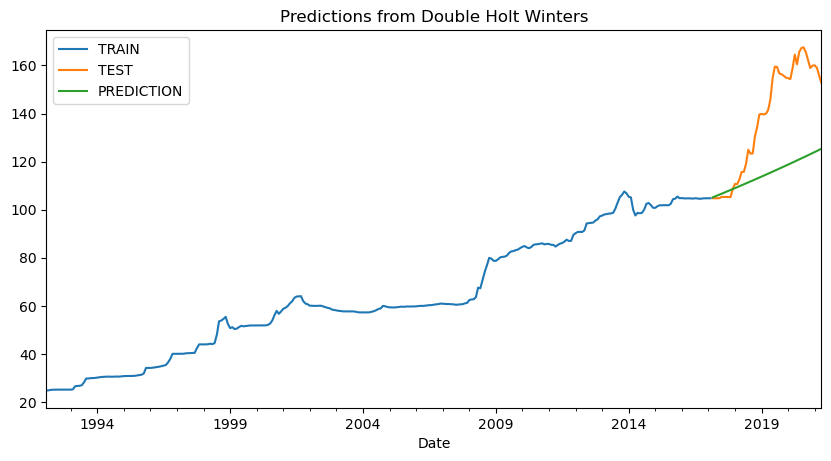

In [40]:
# forecast with double exponential smoothing is better

double_exp_model = ExponentialSmoothing(train_data1['Price'],trend='mul').fit()
predictions = double_exp_model.forecast(50)

train_data1['Price'].plot(legend=True,label='TRAIN')
test_data1['Price'].plot(legend=True,label='TEST')

predictions.plot(legend=True,label='PREDICTION', figsize=(10,5))

plt.title('Predictions from Double Holt Winters')
plt.savefig('triple holt', dpi=500)

In [33]:
# performance evaluation

print(f'Mean Absolute Error = {mean_absolute_error(test_data1,predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_data1,predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(test_data1, predictions))}')  # root mean square error

Mean Absolute Error = 23.355315523958666
Mean Squared Error = 816.0513922192146
Root Mean Squared Error = 28.566613243771382


In [34]:
predictions.head()

2017-03-01    105.171864
2017-04-01    105.549185
2017-05-01    105.927859
2017-06-01    106.307891
2017-07-01    106.689288
Freq: MS, dtype: float64

In [35]:
predictions.tail()

2020-12-01    123.563030
2021-01-01    124.006331
2021-02-01    124.451223
2021-03-01    124.897711
2021-04-01    125.345801
Freq: MS, dtype: float64

#### predicts closer months well, doesn't predict later months as accurately
#### this is typical of time series forecasting methods - they can only predict the near future - the further we get, the less reliable our predictions will be

### _Triple Exponential Smoothing_

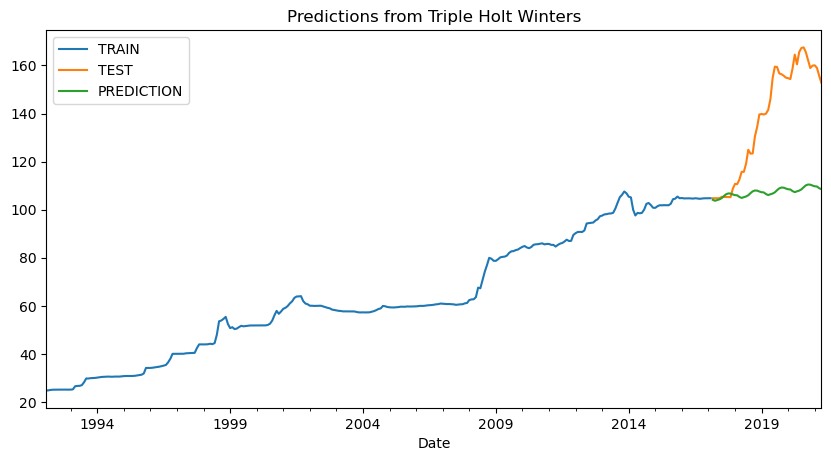

In [41]:
triple_exp_model = ExponentialSmoothing(train_data1['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
predictions = triple_exp_model.forecast(50)

train_data1['Price'].plot(legend=True,label='TRAIN')
test_data1['Price'].plot(legend=True,label='TEST')

predictions.plot(legend=True,label='PREDICTION', figsize=(10,5))

plt.title('Predictions from Triple Holt Winters')
plt.savefig('triple holtt', dpi=500)

In [37]:
# performance evaluation

print(f'Mean Absolute Error = {mean_absolute_error(test_data1,predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_data1,predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(test_data1, predictions))}')  # root mean square error

Mean Absolute Error = 30.608903413642707
Mean Squared Error = 1378.295784254861
Root Mean Squared Error = 37.12540618302864


In [38]:
predictions.head()

2017-03-01    104.131858
2017-04-01    103.727856
2017-05-01    104.051004
2017-06-01    104.332708
2017-07-01    104.838457
Freq: MS, dtype: float64

In [39]:
predictions.tail()

2020-12-01    110.062779
2021-01-01    109.759821
2021-02-01    109.672281
2021-03-01    108.977347
2021-04-01    108.554546
Freq: MS, dtype: float64

#### only predicts closer months accurately because assumes constant mean throughout predictions

# Section 5: Regression Based Methods

### Autocorrelation of non-stationary series

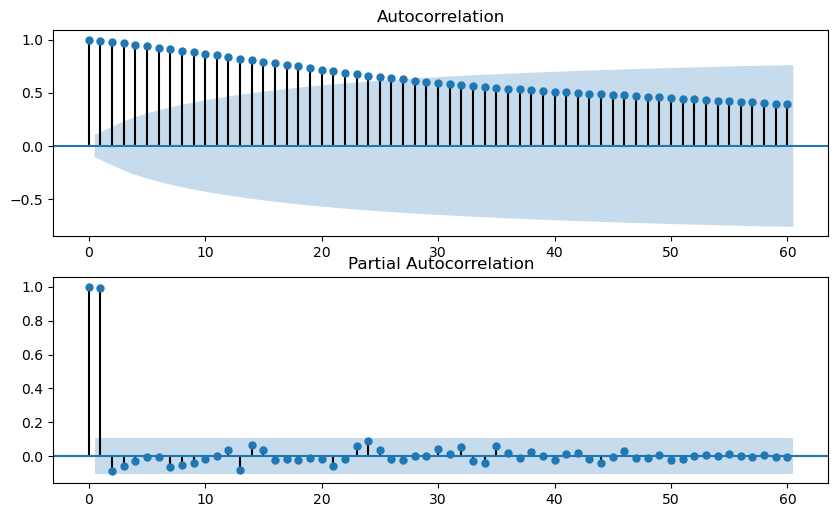

In [20]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data['Price'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data['Price'].dropna(),lags=60,ax=ax2)

### Autocorrelation of stationarized series

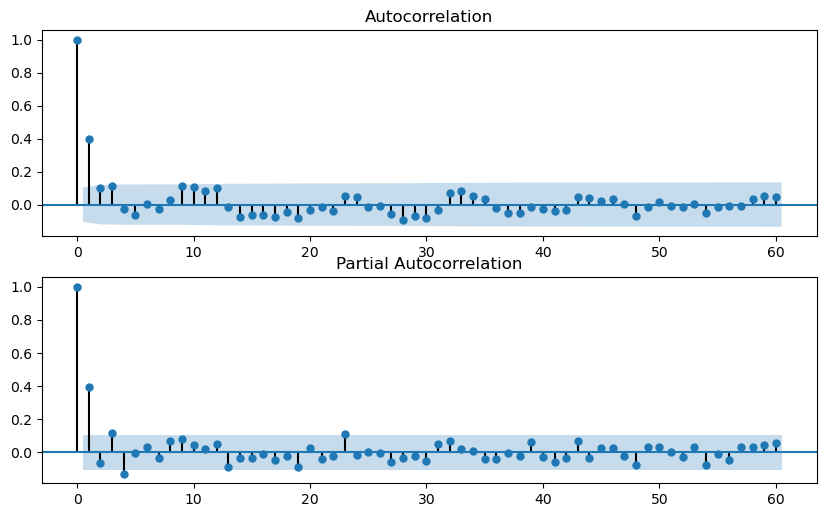

In [21]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data['first_log_difference'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data['first_log_difference'].dropna(),lags=60,ax=ax2)

In [22]:
# for non-seasonal data 
# p=1, d=1, q=1

parameters =  auto_arima(monthly_data['Price'],start_p=0, d=0, start_q=0,               
                          max_p=1, max_d=0, max_q=1, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20 ,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3505.871, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4096.485, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1194.372, Time=0.53 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1183.487, Time=1.28 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1184.510, Time=2.78 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=1184.904, Time=1.61 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1185.141, Time=1.11 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=1186.302, T

In [54]:
training = monthly_data.iloc[:-30]      # first 300 rows , 1992-02-01 to 2017-01-01
testing = monthly_data.iloc[320:351]    # last 31 rows , 2017-02-01 to 2021-04-01

training = training['Price']
testing = testing['Price']
y_test2 = monthly_data.iloc[320:351][['Price']]

print(monthly_data.shape, training.shape, testing.shape)

(351, 6) (321,) (31,)


## a) ARIMA

In [55]:
# fitting arima model

arima_model = ARIMA(monthly_data['Price'], order=(1,0,0)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  351
Model:                     ARMA(1, 0)   Log Likelihood                -626.454
Method:                       css-mle   S.D. of innovations              1.426
Date:                Thu, 27 May 2021   AIC                           1258.907
Time:                        20:58:23   BIC                           1270.490
Sample:                    02-01-1992   HQIC                          1263.517
                         - 04-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          88.1741     60.855      1.449      0.147     -31.100     207.448
ar.L1.Price     0.9997      0.000   2732.472      0.000       0.999       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

Text(0, 0.5, 'Exchange Rate')

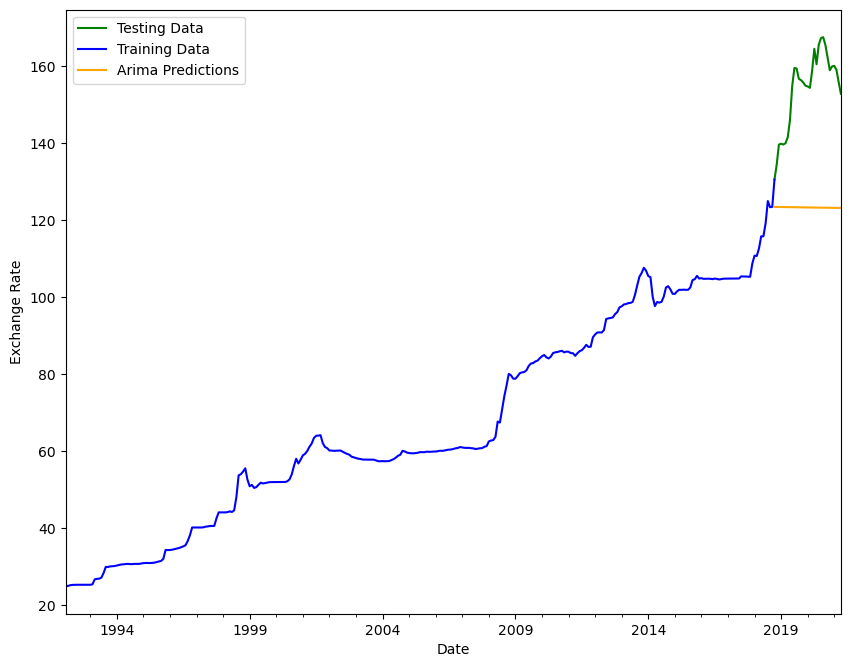

In [56]:
# visualizing results

monthly_data['Arima Predictions'] = arima_model.predict(start=320, end=351, dynamic=True)
arima_predictions = monthly_data['Arima Predictions'].dropna()
testing.plot(label='Testing Data', c='g')
training.plot(label='Training Data',c='b')
monthly_data['Arima Predictions'].plot(c='orange')
plt.legend()
plt.ylabel('Exchange Rate')

In [57]:
# performance evaluation

print(f'Mean Absolute Error = {mean_absolute_error(testing, arima_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(testing, arima_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(testing, arima_predictions))}')

Mean Absolute Error = 30.806025929971614
Mean Squared Error = 1048.3486274600407
Root Mean Squared Error = 32.378212233847016


In [58]:
# predicted and actual values

arima_predictions = pd.DataFrame(arima_predictions).set_index(y_test2.index)
arima_predictions.columns = ['Arima Predictions']
df_arima_pred = pd.concat([y_test2, arima_predictions],axis=1)
df_arima_pred.head()

Price  Arima Predictions
Date                                     
2018-10-01  130.522778         123.410342
2018-11-01  134.365769         123.401087
2018-12-01  139.617692         123.391834
2019-01-01  139.835556         123.382583
2019-02-01  139.615208         123.373335

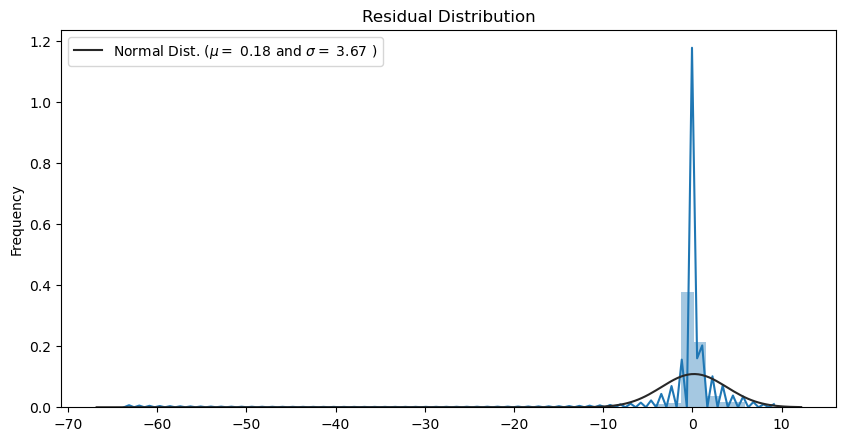

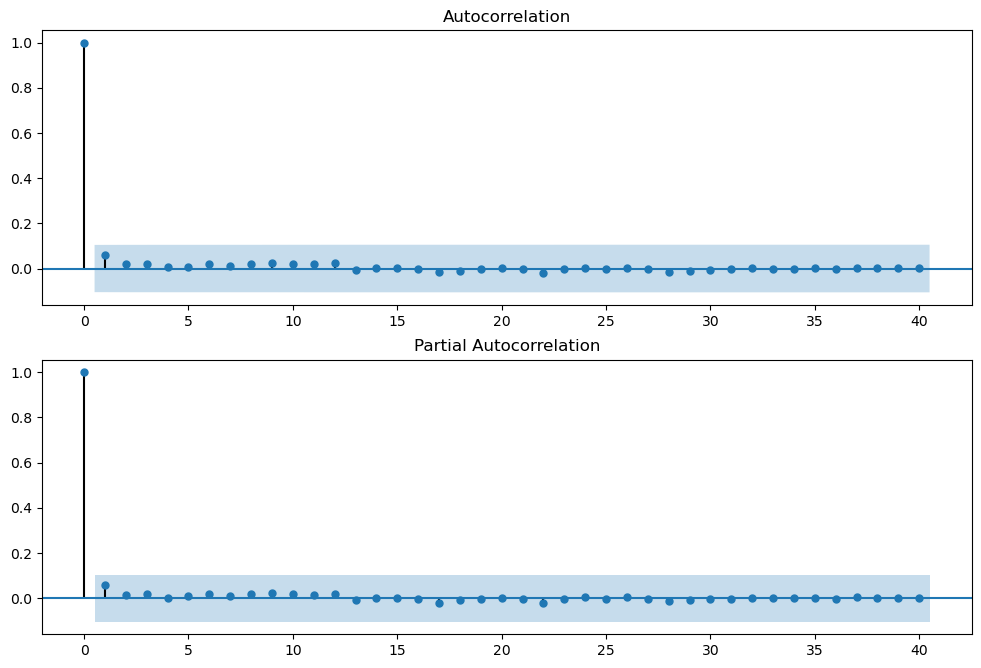

In [59]:
# visualizing residuals

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(111)

sns.distplot(arima_model.resid, fit = stats.norm, ax = ax0) 
(mu, sigma) = stats.norm.fit(arima_model.resid)
plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

### Improving ARIMA using Auto-ARIMA

In [60]:
# fitting auto arima model

new_arima = auto_arima(monthly_data['Price'], trace=True,vsuppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1167.817, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1222.021, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1168.042, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1167.415, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1243.825, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1168.718, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1169.084, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1166.389, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1168.208, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1166.357, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1167.996, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1168.815, Time=0.72 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1174.509, Time=0.07 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 3.626 seconds


In [61]:
# auto arima model summary

monthly_data2 = monthly_data[['Price']]
arima_model2 = ARIMA(monthly_data2['Price'], order=(0,1,3)).fit()
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  350
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -578.178
Method:                       css-mle   S.D. of innovations              1.262
Date:                Thu, 27 May 2021   AIC                           1166.357
Time:                        20:58:29   BIC                           1185.646
Sample:                    03-01-1992   HQIC                          1174.035
                         - 04-01-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3598      0.109      3.302      0.001       0.146       0.573
ma.L1.D.Price     0.4098      0.053      7.780      0.000       0.307       0.513
ma.L2.D.Price     0.0960      0.059      1.631      0.103      -0.019       0.211
ma.L3.D.Price     0.1117      0.051      2.203      0.028       0.012       0.211
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.7298           -0.0000j            1.7298           -0.5000
MA.2            0.4354           -2.2327j            2.2748           -0.2193
MA.3            0.4354           +2.2327j            2.2748            0.2193
-----------------------------------------------------------------------------
"""

Text(0, 0.5, 'Exchange Rate')

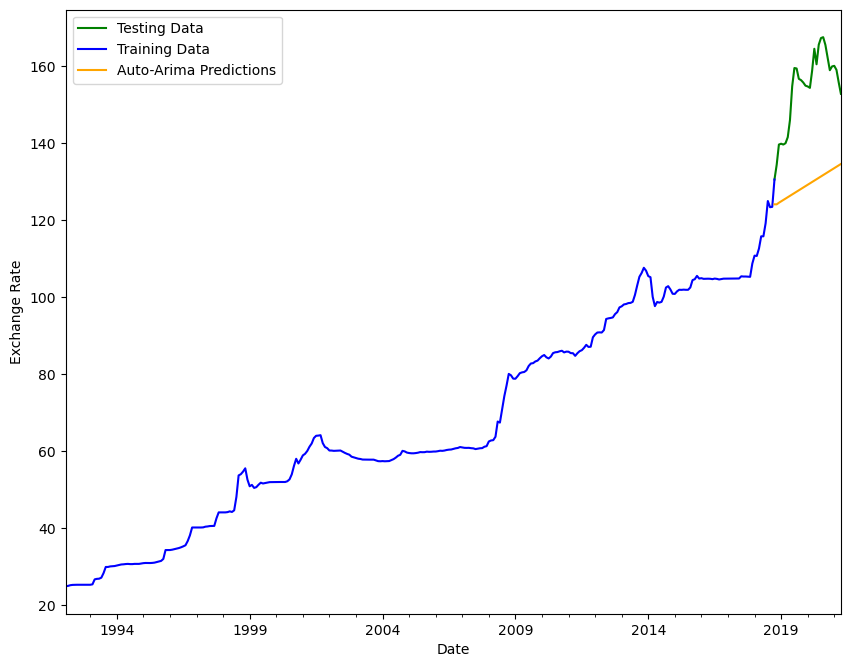

In [62]:
# visualizing results

monthly_data['Auto-Arima Predictions'] = arima_model2.predict(start=320,end=351,typ='levels',dynamic=True)
testing.plot(label='Testing Data', c='g')
training.plot(label='Training Data',c='b')
monthly_data['Auto-Arima Predictions'].plot(c='orange')
plt.legend()
plt.ylabel('Exchange Rate')

In [63]:
# performance evaluation

autoarima_pred = monthly_data['Auto-Arima Predictions'].dropna()
print(f'Mean Absolute Error = {mean_absolute_error(testing, autoarima_pred)}')
print(f'Mean Squared Error = {mean_squared_error(testing, autoarima_pred)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(testing, autoarima_pred))}')

Mean Absolute Error = 24.901997206469023
Mean Squared Error = 680.1765942289624
Root Mean Squared Error = 26.080195440773874


In [64]:
# predicted and actual values

Arima_pred_2 = pd.DataFrame(autoarima_pred).set_index(y_test2.index)
Arima_pred_2.columns = ['Auto Arima Predictions']
df_autoarima_pred = pd.concat([y_test2, Arima_pred_2],axis=1)
df_autoarima_pred.head()

Price  Auto Arima Predictions
Date                                          
2018-10-01  130.522778              124.081733
2018-11-01  134.365769              124.071818
2018-12-01  139.617692              124.490714
2019-01-01  139.835556              124.850488
2019-02-01  139.615208              125.210263

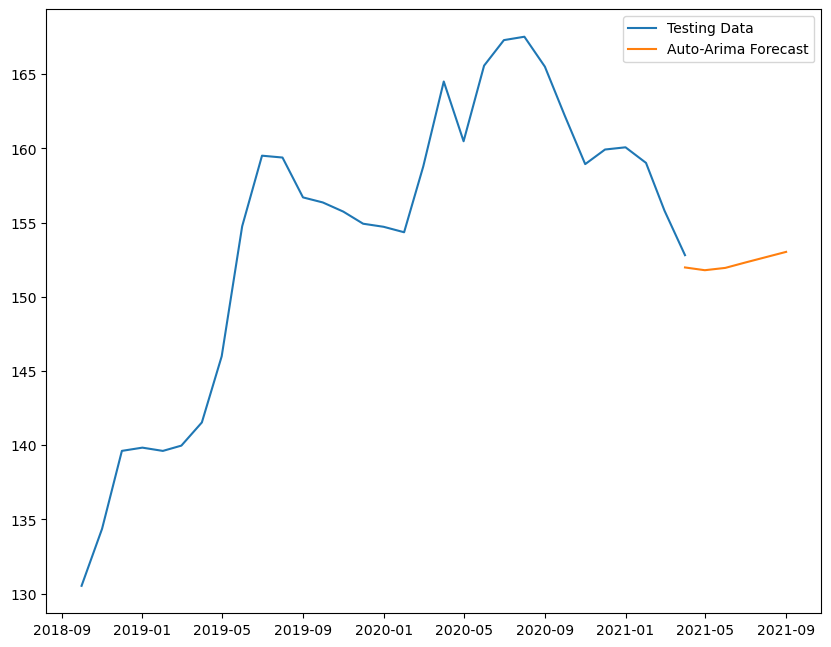

In [65]:
# forecasting next 6 months from auto-arima

dates = pd.date_range("2021-04-01", periods=6, freq="MS")
arima_forecast = arima_model2.forecast(steps=6, alpha=0.05)
predictt = pd.DataFrame(arima_forecast[0], columns = ['Auto-Arima Forecast'])
predictt.set_index(dates, inplace=True)
#plt.ylabel('Price')
plt.plot(testing, label='Testing Data')
plt.plot(predictt, label='Auto-Arima Forecast')
plt.legend()

In [66]:
# removing covid years
coviddata = pd.read_csv('usd-pkr.csv')
coviddata = coviddata[:-675]
coviddata = coviddata[['Price','Date']]
coviddata['Date'] = pd.to_datetime(coviddata['Date'])
coviddata = coviddata.resample('MS', on='Date').mean().reset_index().sort_values(by='Date')
coviddata = coviddata.set_index('Date')

covtraining = coviddata.iloc[:293]
covtesting = coviddata.iloc[293:]
covtraining = covtraining['Price']
covtesting = covtesting['Price']
covy_test2 = coviddata.iloc[293:][['Price']]

coviddata2 = coviddata[['Price']]
covarima_model2 = ARIMA(coviddata['Price'], order=(0,1,3)).fit()
covarima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  322
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -450.027
Method:                       css-mle   S.D. of innovations              0.978
Date:                Thu, 27 May 2021   AIC                            910.054
Time:                        20:58:32   BIC                            928.927
Sample:                    03-01-1992   HQIC                           917.589
                         - 12-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3711      0.097      3.814      0.000       0.180       0.562
ma.L1.D.Price     0.4369      0.054      8.049      0.000       0.331       0.543
ma.L2.D.Price     0.1023      0.058      1.775      0.076      -0.011       0.215
ma.L3.D.Price     0.2494      0.056      4.434      0.000       0.139       0.360
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3388           -0.0000j            1.3388           -0.5000
MA.2            0.4643           -1.6673j            1.7307           -0.2068
MA.3            0.4643           +1.6673j            1.7307            0.2068
-----------------------------------------------------------------------------
"""

Text(0, 0.5, 'Exchange rate')

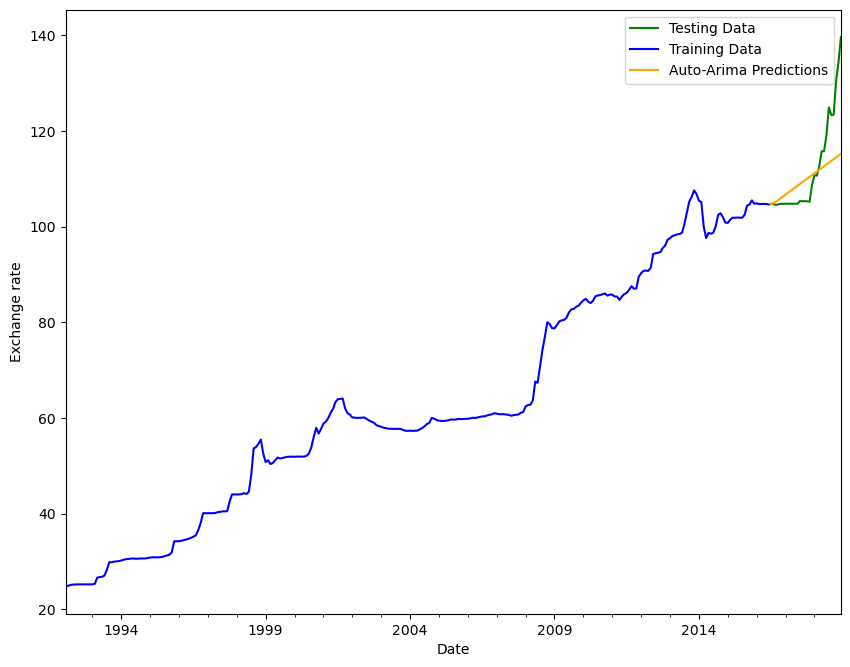

In [67]:
# visualizing results

coviddata['Auto-Arima Predictions'] = covarima_model2.predict(start=293,end=322,typ='levels',dynamic=True)
pred = coviddata['Auto-Arima Predictions'].dropna()
covtesting.plot(label='Testing Data', c='g')
covtraining.plot(label='Training Data',c='b')
pred.plot(c='orange')
plt.legend()
plt.ylabel('Exchange rate')

In [68]:
# performance evaluation

cov_autoarima_pred = coviddata['Auto-Arima Predictions'].dropna()
print(f'Mean Absolute Error = {mean_absolute_error(covtesting, cov_autoarima_pred)}')
print(f'Mean Squared Error = {mean_squared_error(covtesting, cov_autoarima_pred)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(covtesting, cov_autoarima_pred))}')

Mean Absolute Error = 5.027451097069903
Mean Squared Error = 58.714709697706226
Root Mean Squared Error = 7.66255242707717


## b) SARIMA

In [69]:
sarima_model = SARIMAX(monthly_data['Price'], order=(1,0,1), seasonal_order=(1,0,0,12)).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Price   No. Observations:                  351
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -587.363
Date:                             Thu, 27 May 2021   AIC                           1182.726
Time:                                     20:58:33   BIC                           1198.169
Sample:                                 02-01-1992   HQIC                          1188.873
                                      - 04-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   2053.003      0.000       0.999       1.001
ma.L1          0.4299      0.024     17.717      0.000       0.382       0.477
ar.S.L12       0.2090      0.029      7.215      0.000       0.152       0.266
sigma2         1.6188      0.055     29.493      0.000       1.511       1.726
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1118.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.18   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Exchange Rate')

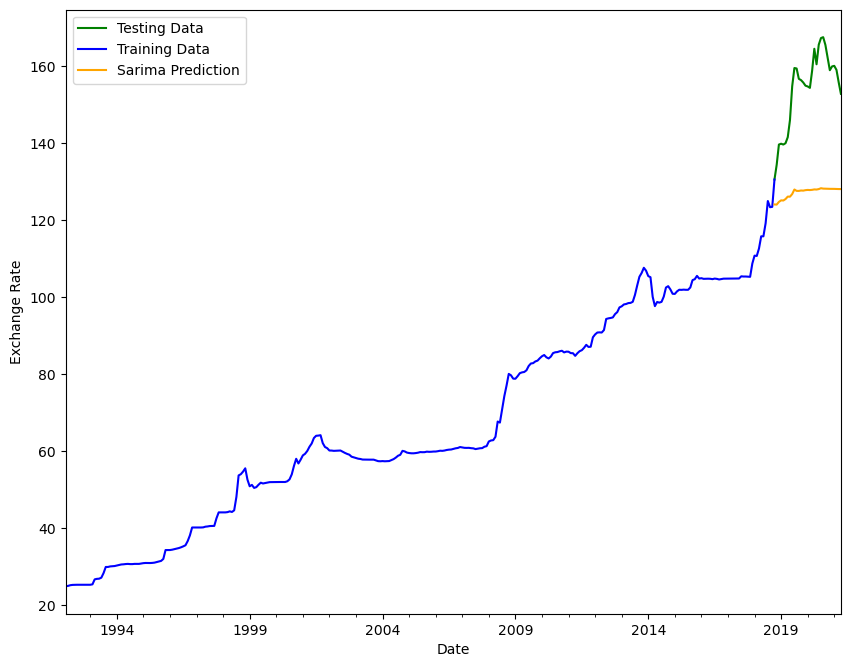

In [70]:
# visualizing results 

monthly_data['Sarima Prediction']=sarima_model.predict(start=320, end=351, dynamic=True)
sarima_predictions = monthly_data['Sarima Prediction'].dropna()
testing.plot(label='Testing Data', c='g')
training.plot(label='Training Data',c='b')
monthly_data['Sarima Prediction'].plot(c='orange')
plt.legend()
plt.ylabel('Exchange Rate')

In [71]:
# performance evaluation

print(f'Mean Absolute Error = {mean_absolute_error(testing, sarima_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(testing, sarima_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(testing, sarima_predictions))}')

Mean Absolute Error = 26.915795073089804
Mean Squared Error = 799.6816625995542
Root Mean Squared Error = 28.27864322416396


In [72]:
# predicted and actual values

sarima_predictions = pd.DataFrame(sarima_predictions).set_index(y_test2.index)
sarima_predictions.columns = ['Sarima Predictions']
df_sarima_pred = pd.concat([y_test2, sarima_predictions],axis=1)
df_sarima_pred.tail()

Price  Sarima Predictions
Date                                      
2020-12-01  159.927273          128.107280
2021-01-01  160.076190          128.095295
2021-02-01  159.026667          128.063935
2021-03-01  155.805217          128.050883
2021-04-01  152.807381          128.049235

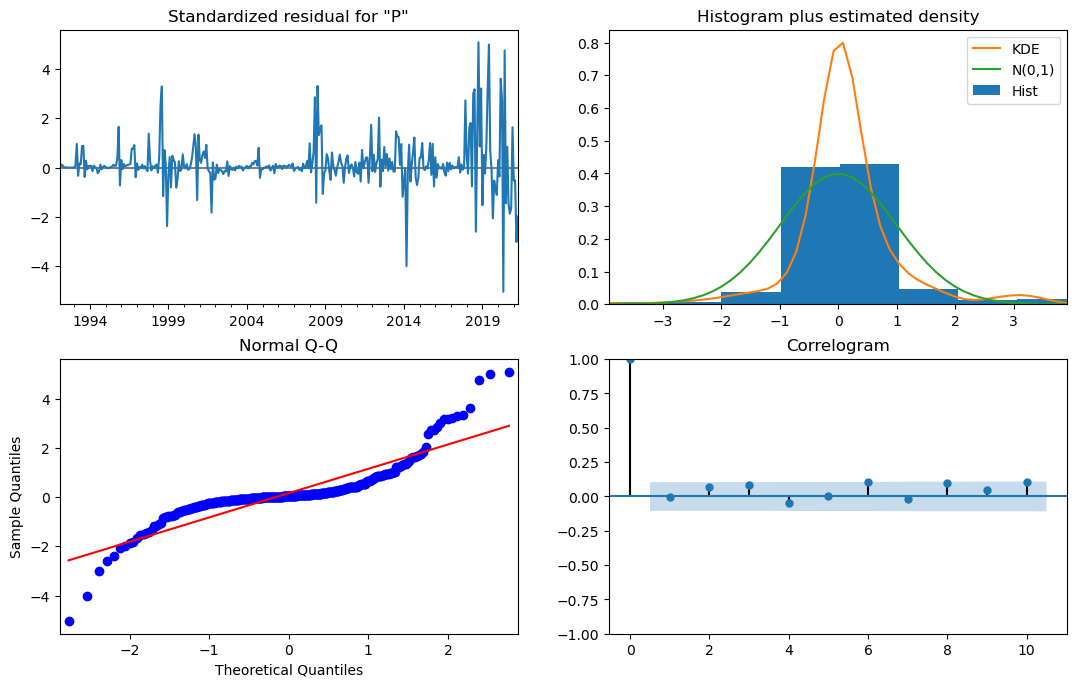

In [73]:
# visualizing residuals

sarima_model.plot_diagnostics(figsize=(13,8))
plt.show()

In [74]:
# removing Covid years

cov_sarima_model = SARIMAX(coviddata['Price'], order=(1,0,1), seasonal_order=(1,0,0,12)).fit()
cov_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Price   No. Observations:                  323
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -469.431
Date:                             Thu, 27 May 2021   AIC                            946.863
Time:                                     20:58:36   BIC                            961.973
Sample:                                 02-01-1992   HQIC                           952.895
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   2922.546      0.000       0.999       1.001
ma.L1          0.5300      0.025     21.151      0.000       0.481       0.579
ar.S.L12       0.1917      0.059      3.277      0.001       0.077       0.306
sigma2         1.0383      0.037     28.417      0.000       0.967       1.110
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1326.99
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Exchange rate')

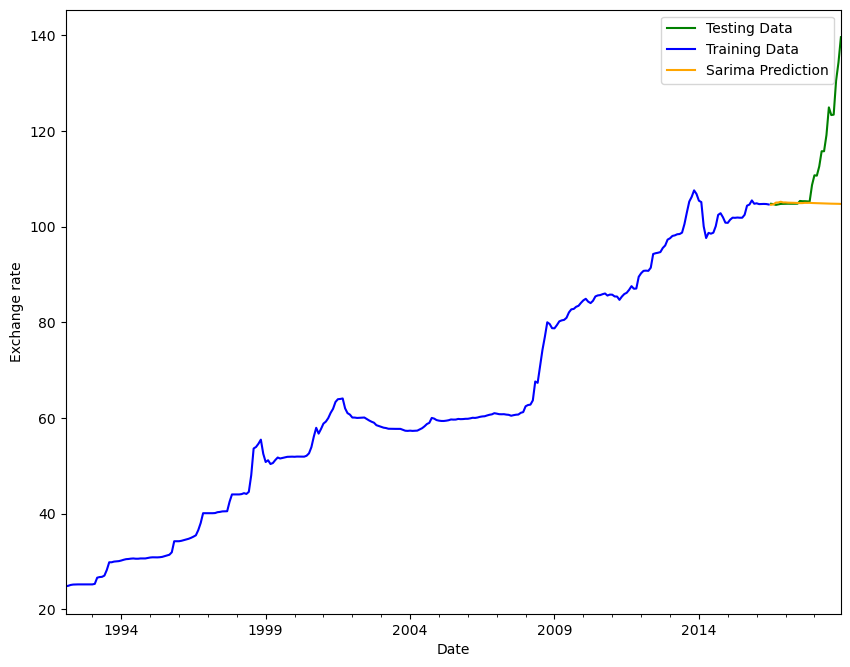

In [75]:
#visualizing results

coviddata['Sarima Prediction'] = cov_sarima_model.predict(start=293, end=323, dynamic=True)
cov_sarima_predictions = coviddata['Sarima Prediction'].dropna()
covtesting.plot(label='Testing Data', c='g')
covtraining.plot(label='Training Data',c='b')
coviddata['Sarima Prediction'].plot(c='orange')
plt.legend()
plt.ylabel('Exchange rate')

In [76]:
# performance evaluation

print(f'Mean Absolute Error = {mean_absolute_error(covtesting, cov_sarima_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(covtesting, cov_sarima_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(covtesting, cov_sarima_predictions))}')

Mean Absolute Error = 7.048870126249864
Mean Squared Error = 147.7934165861422
Root Mean Squared Error = 12.15703156967778


### Improving SARIMA using Rolling Forecasts

In [77]:
sarimaxx = df1.resample('MS', on='Date').mean().reset_index().sort_values(by='Date')
sarimaxx = sarimaxx.set_index('Date')

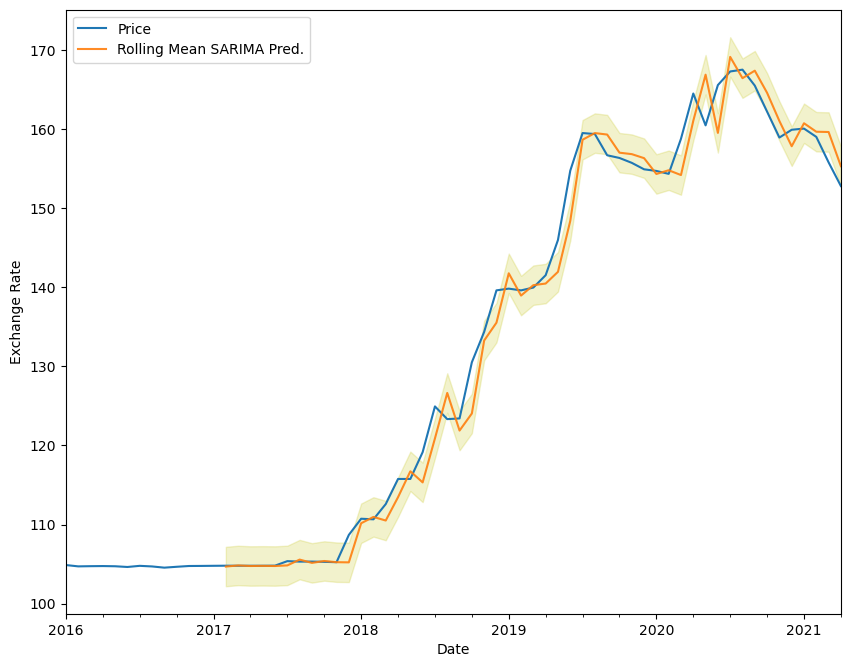

In [78]:
# fitting rolling mean model

sarima_prediction = sarima_model.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
sarima_pred_conf = sarima_prediction.conf_int()                            # upper lower bound 

ax = sarimaxx['2016':].plot(label='observed')
sarima_prediction.predicted_mean.plot(ax=ax, label='Rolling Mean SARIMA Pred.', alpha=.9)

ax.fill_between(sarima_pred_conf.index,
                sarima_pred_conf.iloc[:, 0],
                sarima_pred_conf.iloc[:, 1], color='y', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
plt.legend()
plt.savefig('roll pred',dpi=200)
plt.show()

In [79]:
# preformance evaluation 

testing1 = sarimaxx.iloc[300:]
print(f'Mean Absolute Error = {mean_absolute_error(testing1, sarima_prediction.predicted_mean)}')
print(f'Mean Squared Error = {mean_squared_error(testing1, sarima_prediction.predicted_mean)}')
print(f'Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(testing1, sarima_prediction.predicted_mean))}')
print('R-Square:', metrics.r2_score(testing1, sarima_prediction.predicted_mean))

Mean Absolute Error = 1.8991104193376411
Mean Squared Error = 6.986007027204467
Root Mean Squared Error = 2.6431055648998334
R-Square: 0.9867097557020794


In [80]:
# predicted and actual values

rm_sarima_predictions = pd.DataFrame(sarima_prediction.predicted_mean).set_index(testing1.index)
rm_sarima_predictions.columns = ['Rolling Mean Sarima Predictions']
df_rmsarima_pred = pd.concat([testing1, rm_sarima_predictions],axis=1)
df_rmsarima_pred.head()

Price  Rolling Mean Sarima Predictions
Date                                                   
2017-02-01  104.795893                       104.688636
2017-03-01  104.791129                       104.827126
2017-04-01  104.789000                       104.758667
2017-05-01  104.790000                       104.776971
2017-06-01  104.802667                       104.756341

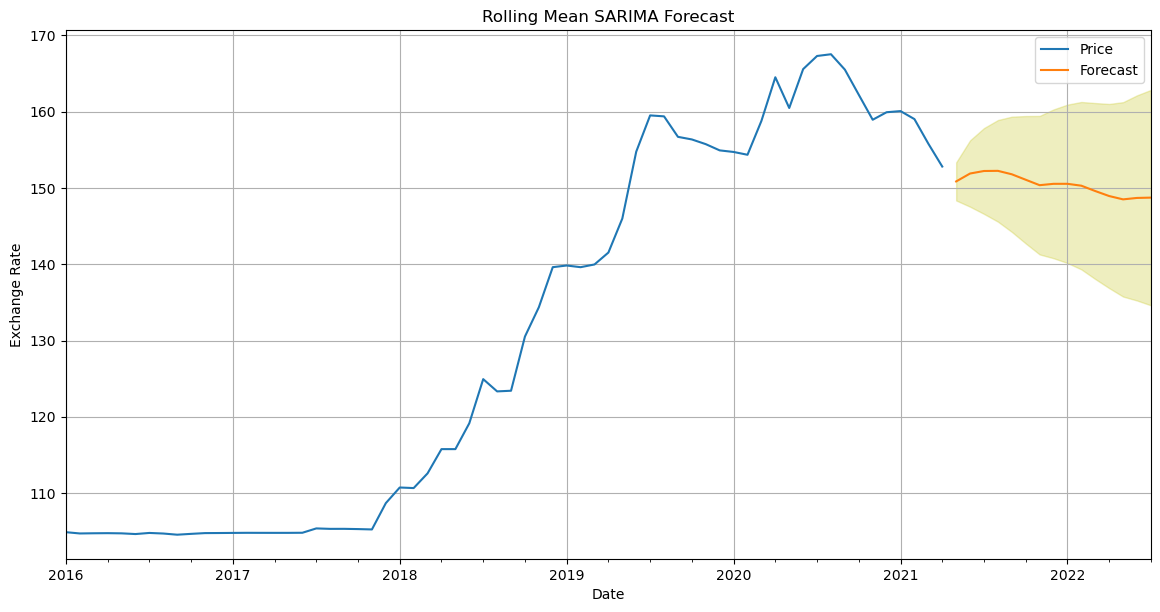

In [81]:
# forecast of next 15 months 

sarima_forecast = sarima_model.get_forecast(steps=15)
sarima_forecast_conf = sarima_forecast.conf_int()

ax = sarimaxx['2016':].plot(label='observed', figsize=(14, 7))
sarima_forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(sarima_forecast_conf.index,
                sarima_forecast_conf.iloc[:, 0],
                sarima_forecast_conf.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
plt.grid()
plt.legend()
plt.title('Rolling Mean SARIMA Forecast')
plt.savefig('roll forecast',dpi=200)
plt.show()

In [85]:
rm_sarima_forecast = pd.DataFrame(sarima_forecast.predicted_mean)
rm_sarima_forecast.columns = ['Rolling Mean Sarima Forecast']
#df_rmsarima_forecast = pd.concat([testing1, rm_sarima_forecast],axis=1)
#df_rmsarima_forecast.head()
rm_sarima_forecast

Rolling Mean Sarima Forecast
2021-05-01                    150.856289
2021-06-01                    151.892983
2021-07-01                    152.224552
2021-08-01                    152.243904
2021-09-01                    151.794106
2021-10-01                    151.077175
2021-11-01                    150.364460
2021-12-01                    150.541977
2022-01-01                    150.544840
2022-02-01                    150.297215
2022-03-01                    149.595625
2022-04-01                    148.940782
2022-05-01                    148.504733
2022-06-01                    148.693191
2022-07-01                    148.734272

#### In May 2021 the actual recorded exchange rate is 152.25 which is what our model predicted as well. However, as we move further away from May to later months the model may not predict as confidently which can be observed through the widening confidence interval.

# Section 6: Supervised Machine Learning Methods

In [4]:
# converting data into a supervised machine learning problem

data = pd.read_csv('usd-pkr.csv')
data['Date'] =  pd.to_datetime(data['Date'])

data = data[['Date','Price','Open','High','Low']]
data['Month'] = data['Date'].dt.month.astype(np.float64)
data['Day'] = data['Date'].dt.day.astype(np.float64)
data['WeekDay'] = data['Date'].dt.dayofweek.astype(np.float64)
data['Quarter'] = data['Date'].dt.quarter.astype(np.float64)
data['Year'] = data['Date'].dt.year.astype(np.float64)
data['Dayofyear'] = data['Date'].dt.dayofyear.astype(np.float64)


data['Previous Price'] = data['Price'].shift(1)
data['Second Previous Price'] = data['Price'].shift(2)
data['Third Previous Price']=data['Price'].shift(3)
data['Fourth Previous Price']=data['Price'].shift(4)

#data['Fifth Previous Price']=data['Price'].shift(5)
#data['Sixth Previous Price']=data['Price'].shift(6)
#data['Seventh Previous Price']=data['Price'].shift(7)
#data['Next Price'] = data['Price'].shift(-1)

data = data.dropna()
data

Date    Price     Open     High      Low  Month   Day  WeekDay  \
4    1992-02-11   24.802   24.802   24.802   24.802    2.0  11.0      1.0   
5    1992-02-12   24.802   24.802   24.802   24.802    2.0  12.0      2.0   
6    1992-02-13   24.802   24.802   24.802   24.802    2.0  13.0      3.0   
7    1992-02-14   24.802   24.802   24.802   24.802    2.0  14.0      4.0   
8    1992-02-17   24.802   24.802   24.802   24.802    2.0  17.0      0.0   
...         ...      ...      ...      ...      ...    ...   ...      ...   
8157 2021-04-23  153.250  153.600  154.000  152.925    4.0  23.0      4.0   
8158 2021-04-24  153.700  153.875  153.875  153.875    4.0  24.0      5.0   
8159 2021-04-26  153.925  153.625  154.050  153.375    4.0  26.0      0.0   
8160 2021-04-27  154.350  153.925  155.150  153.925    4.0  27.0      1.0   
8161 2021-04-28  154.050  154.475  155.150  152.900    4.0  28.0      2.0   

      Quarter    Year  Dayofyear  Previous Price  Second Previous Price  \
4         1.0  1992.0       42.0          24.802                 24.802   
5         1.0  1992.0       43.0          24.802                 24.802   
6         1.0  1992.0       44.0          24.802                 24.802   
7         1.0  1992.0       45.0          24.802                 24.802   
8         1.0  1992.0       48.0          24.802                 24.802   
...       ...     ...        ...             ...                    ...   
8157      2.0  2021.0      113.0         153.200                152.500   
8158      2.0  2021.0      114.0         153.250                153.200   
8159      2.0  2021.0      116.0         153.700                153.250   
8160      2.0  2021.0      117.0         153.925                153.700   
8161      2.0  2021.0      118.0         154.350                153.925   

      Third Previous Price  Fourth Previous Price  
4                   24.802                 24.802  
5                   24.802                 24.802  
6                   24.802                 24.802  
7                   24.802                 24.802  
8                   24.802                 24.802  
...                    ...                    ...  
8157               152.600                152.600  
8158               152.500                152.600  
8159               153.200                152.500  
8160               153.250                153.200  
8161               153.700                153.250  

[8158 rows x 15 columns]

In [5]:
data_train = data.iloc[:-30]
#data_train = monthly_data.set_index('Date')

data_test = data.iloc[8128:]
X_train = data_train.drop(columns=['Price','Date'])
y_train = data_train[['Price']]
X_test = data_test.drop(columns=['Price','Date'])
y_test = data_test[['Price']]
y_test1 = data_test[['Price','Date']].set_index('Date')  

## a) Linear Regression

In [6]:
# fitting linear regression model

lin_model=LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

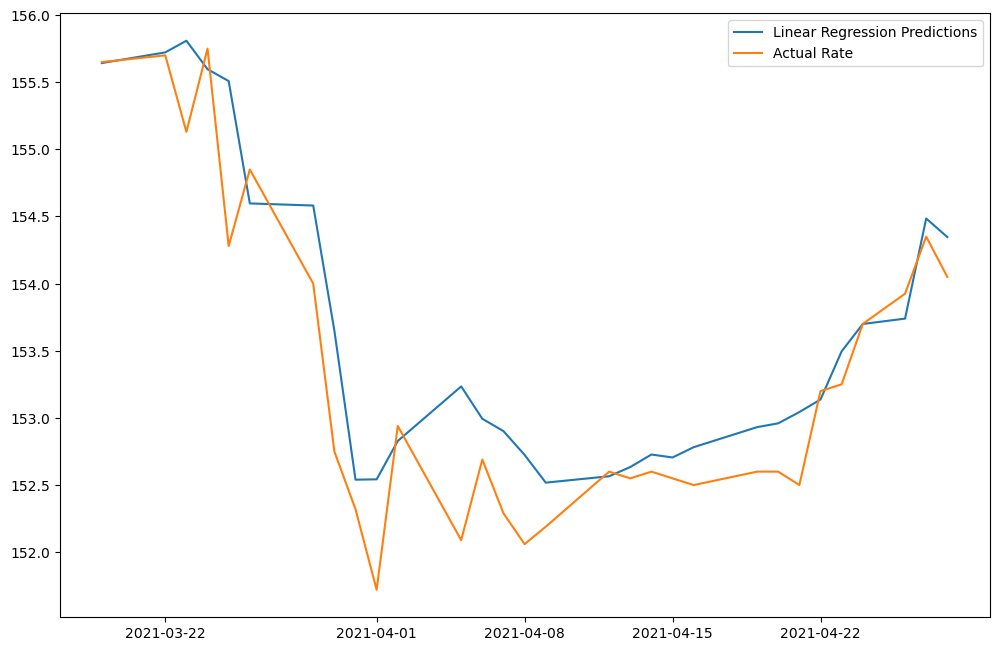

In [9]:
# predictions

lin_prediction = lin_model.predict(X_test)

lin_prediction.astype(np.float64)
lin_prediction = pd.DataFrame(lin_prediction).set_index(y_test1.index)
lin_prediction.columns = ['Linear Reg Predictions']
df_lin_pred = pd.concat([y_test1, lin_prediction],axis=1)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(df_lin_pred['Linear Reg Predictions'],label='Linear Regression Predictions')
plt.plot(df_lin_pred['Price'],label='Actual Rate')
plt.legend()
plt.savefig('lin reg', dpi=500)
plt.show()

In [10]:
# results

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_prediction)))
print('R-Square:', metrics.r2_score(y_test, lin_prediction))

Mean Absolute Error: 0.3625766941394109
Mean Squared Error: 0.23795589910894113
Root Mean Squared Error: 0.4878072356053579
R-Square: 0.8241266975792289


In [11]:
# predicted vs actual values

df_lin_pred.tail()

Price  Linear Reg Predictions
Date                                       
2021-04-23  153.250              153.495844
2021-04-24  153.700              153.699583
2021-04-26  153.925              153.739512
2021-04-27  154.350              154.485036
2021-04-28  154.050              154.347075

## b) Random Forest

In [12]:
# fitting Random Forest 

ranfor_model = RandomForestRegressor(n_estimators=100, max_features=4, criterion='mae', random_state=2)
ranfor_model.fit(X_train,y_train)

RandomForestRegressor(criterion='mae', max_features=4, random_state=2)

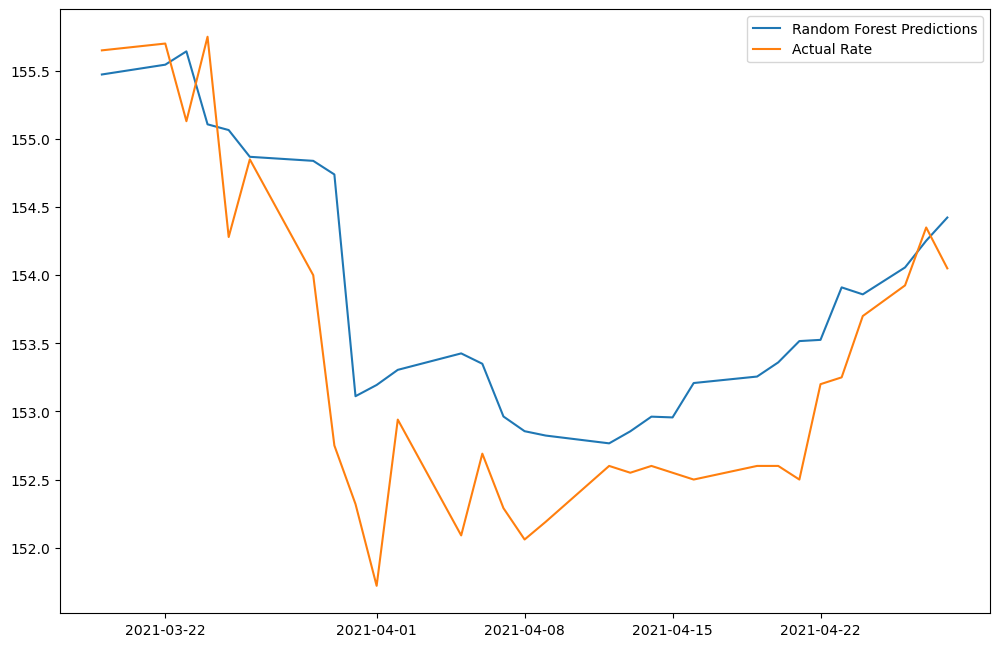

In [13]:
# predictions

ranfor_prediction = ranfor_model.predict(X_test)
ranfor_prediction.astype(np.float64)
ranfor_prediction = pd.DataFrame(ranfor_prediction).set_index(y_test1.index)
ranfor_prediction.columns = ['Random Forest Predictions']
df_ranfor_pred = pd.concat([y_test1, ranfor_prediction],axis=1)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(df_ranfor_pred['Random Forest Predictions'],label='Random Forest Predictions')
plt.plot(df_ranfor_pred['Price'],label='Actual Rate')
plt.legend()
plt.show()

In [14]:
# results

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ranfor_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ranfor_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ranfor_prediction)))
print('R-Square:', metrics.r2_score(y_test, ranfor_prediction))

Mean Absolute Error: 0.5990366666666859
Mean Squared Error: 0.5445878106667065
Root Mean Squared Error: 0.7379619303640984
R-Square: 0.5974949262501705


In [15]:
# predicted vs actual values

df_ranfor_pred.head()

Price  Random Forest Predictions
Date                                         
2021-03-19  155.65                  155.47295
2021-03-22  155.70                  155.54490
2021-03-23  155.13                  155.64275
2021-03-24  155.75                  155.10710
2021-03-25  154.28                  155.06505

## c) XGBoost

In [16]:
# fitting xgboost

xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

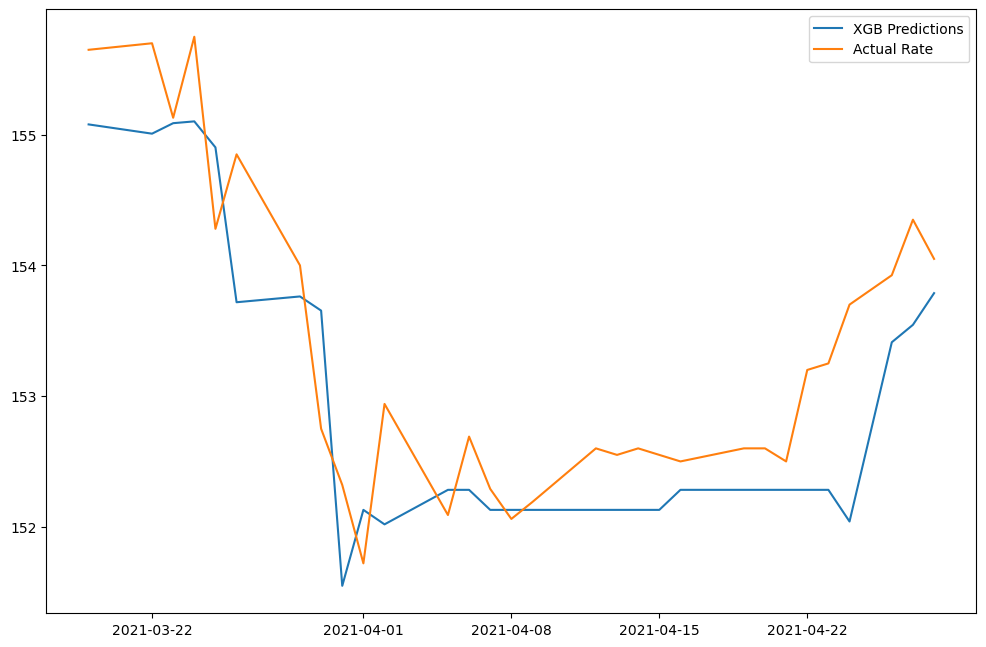

In [17]:
# predictions

xgb_prediction = xgb_model.predict(X_test)

xgb_prediction.astype(np.float64)
xgb_prediction = pd.DataFrame(xgb_prediction).set_index(y_test1.index)
xgb_prediction.columns = ['XGB Predictions']
df_xgb_pred = pd.concat([y_test1, xgb_prediction],axis=1)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(df_xgb_pred['XGB Predictions'],label='XGB Predictions')
plt.plot(df_xgb_pred['Price'],label='Actual Rate')
plt.legend()
plt.show()

In [18]:
# results

print('Mean Absolute Error:', mean_absolute_error(y_test,xgb_prediction))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, xgb_prediction)))
print('R-Square:', metrics.r2_score(y_test, xgb_prediction))

Mean Absolute Error: 0.5273002929687484
Mean Squared Error: 0.4074522490006158
Root Mean Squared Error: 0.6383198641751765
R-Square: 0.6988518760037076


In [19]:
# predicted vs actual values

df_xgb_pred.tail()

Price  XGB Predictions
Date                                
2021-04-23  153.250       152.282608
2021-04-24  153.700       152.040344
2021-04-26  153.925       153.411942
2021-04-27  154.350       153.545486
2021-04-28  154.050       153.787750

## d) Multi Layer Perceptron

In [20]:
# fitting MLP

mlp_model = MLPRegressor(hidden_layer_sizes=5, activation='relu', max_iter=500)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=5, max_iter=500)

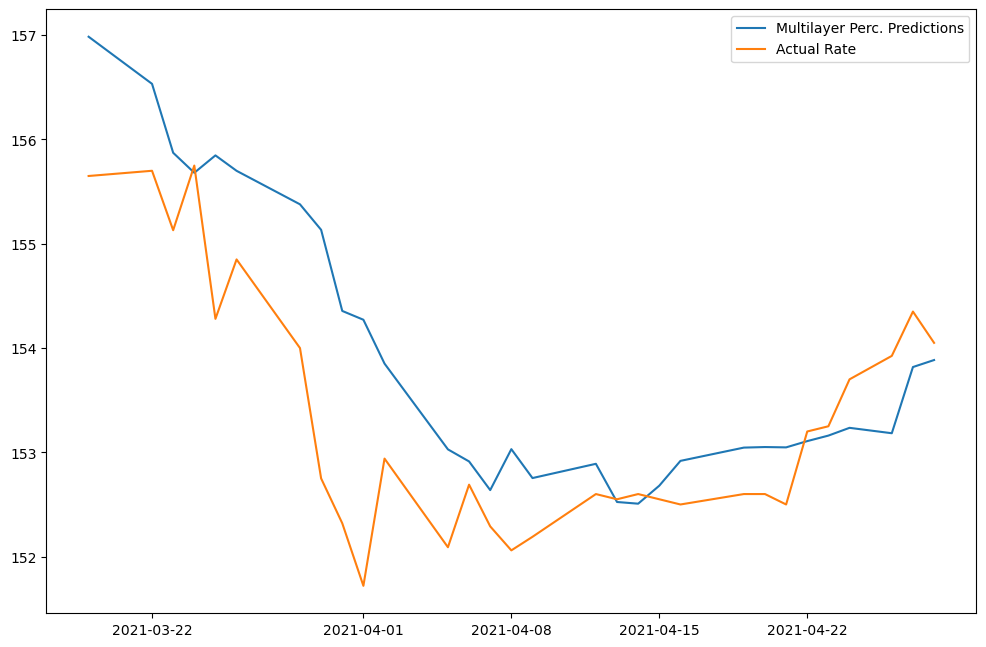

In [21]:
# predictions

mlp_prediction = mlp_model.predict(X_test)

mlp_prediction.astype(np.float64)
mlp_prediction = pd.DataFrame(mlp_prediction).set_index(y_test1.index)
mlp_prediction.columns = ['Multilayer Perc. Predictions']
df_mlp_pred = pd.concat([y_test1, mlp_prediction],axis=1)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(df_mlp_pred['Multilayer Perc. Predictions'],label='Multilayer Perc. Predictions')
plt.plot(df_mlp_pred['Price'],label='Actual Rate')
plt.legend()
plt.show()

In [22]:
# results 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, mlp_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, mlp_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, mlp_prediction)))
print('R-Square:', metrics.r2_score(y_test, mlp_prediction))

Mean Absolute Error: 0.7395889667965709
Mean Squared Error: 0.9890422595783137
Root Mean Squared Error: 0.9945060379798173
R-Square: 0.26899846115559634


In [23]:
# predicted vs actual values

df_mlp_pred.tail()

Price  Multilayer Perc. Predictions
Date                                             
2021-04-23  153.250                    153.160599
2021-04-24  153.700                    153.235022
2021-04-26  153.925                    153.183231
2021-04-27  154.350                    153.817977
2021-04-28  154.050                    153.885122

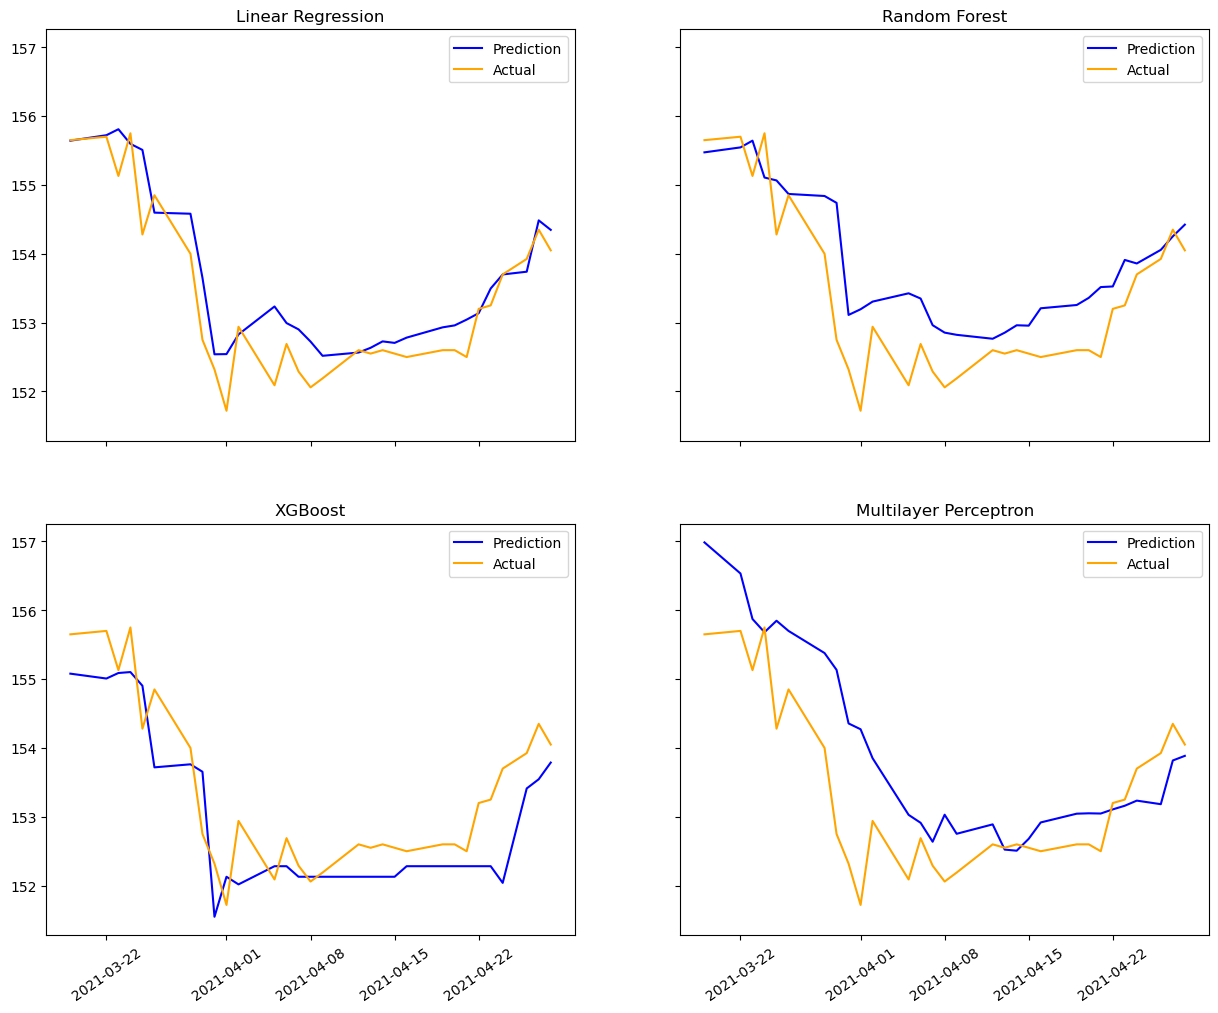

In [56]:
a=df_lin_pred.index
fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,12))
axs[0,0].plot(df_lin_pred.index, df_lin_pred['Linear Reg Predictions'], label='Prediction', color='b')
axs[0,0].plot(df_lin_pred.index, df_lin_pred['Price'], label='Actual', color='orange')
axs[0,0].set_title('Linear Regression')
axs[0,0].legend()
#plt.xticks(rotation=45)
axs[0,1].plot(df_ranfor_pred.index, df_ranfor_pred['Random Forest Predictions'], label='Prediction',c='b')
axs[0,1].plot(df_ranfor_pred.index, df_ranfor_pred['Price'],label='Actual',c='orange')
axs[0,1].set_title('Random Forest')
axs[0,1].legend()
#plt.xticks(rotation=45)
axs[1,0].plot(df_xgb_pred.index, df_xgb_pred['XGB Predictions'],label='Prediction',c='b')
axs[1,0].plot(df_xgb_pred.index, df_xgb_pred['Price'],label='Actual',c='orange')
axs[1,0].set_title('XGBoost')
axs[1,0].legend()
#plt.xticks(rotation=45)
axs[1,1].plot(df_mlp_pred.index, df_mlp_pred['Multilayer Perc. Predictions'],label='Prediction', c='b')
axs[1,1].plot(df_mlp_pred.index, df_mlp_pred['Price'],label='Actual', color='orange')
axs[1,1].set_title('Multilayer Perceptron')
axs[1,1].legend()
#plt.xticks(rotation=45)
for ax in axs.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(35)
fig.savefig('reg models', dpi=500, bbox_inches='tight')

# Section 7: Multivariate Analysis for Vector Auto Regression (VAR) 

In [24]:
df = pd.read_csv('pk-vals.csv', index_col='Date', parse_dates=['Date'])
df = df[['Exchange Rate','Inflation Rate','Current Account','Interest Rate']]
print(df.head()) 

            Exchange Rate  Inflation Rate  Current Account  Interest Rate
Date                                                                     
2004-12-31      58.462917          7.4446        -0.758169      -0.068118
2005-12-31      59.582083          9.0633        -3.003783       1.142346
2006-12-31      60.330000          7.9211        -4.915343       1.942345
2007-12-31      60.836667          7.5987        -5.447361       4.189273
2008-12-31      70.975000         20.2861        -9.204316      -0.236897


## Visualizing all the Series

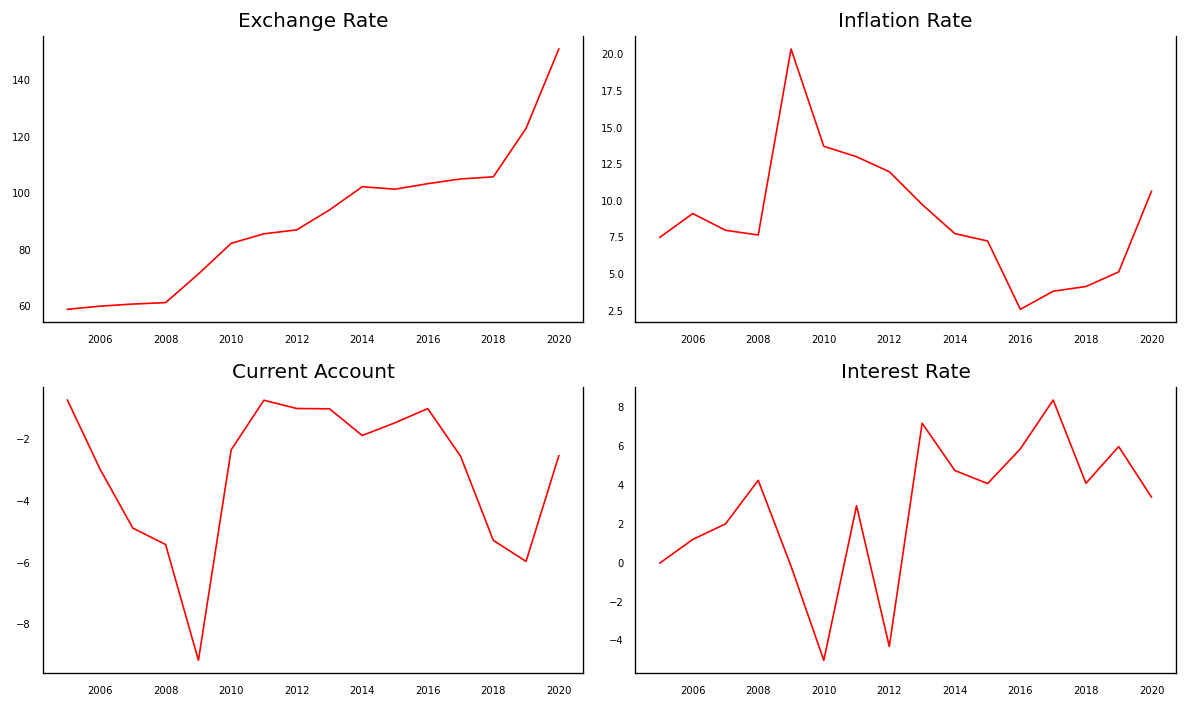

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### _we would have to stationarize all the series before proceeding with VAR_
#### _note that we have 15 years' annual data only_

## Correlation Matrix

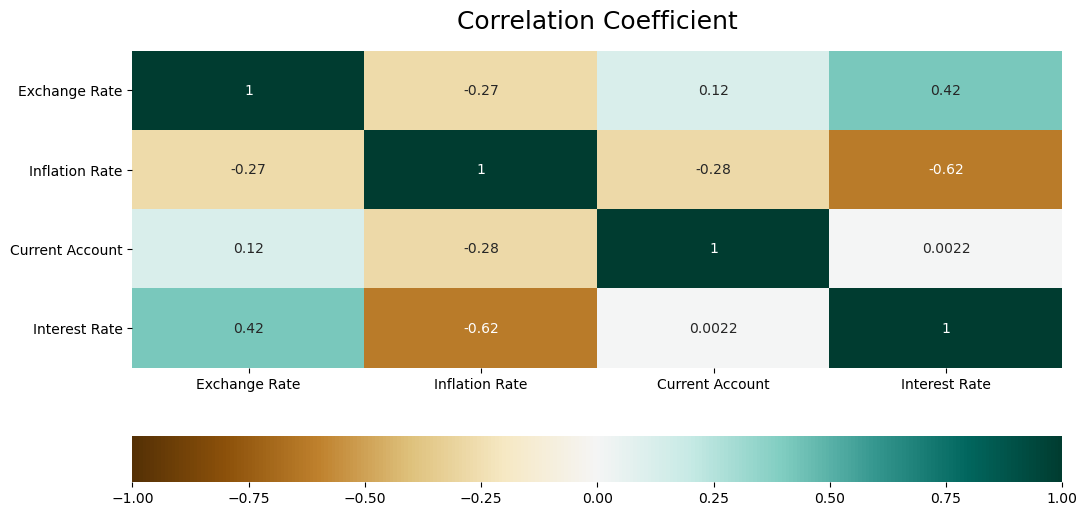

In [91]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=True, cbar_kws={"orientation": "horizontal"})
cbar = heatmap.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, va='center')
heatmap.set_title('Correlation Coefficient', fontdict={'fontsize':18}, pad=16);

##### no significant correlation with Exchange Rate 

## Granger’s Causality Test

In [92]:
max_lags=4
y = 'Exchange Rate'

for i in range(len(df.columns)-1):
    results = grangercausalitytests(df[[y, df.columns[i+1]]], max_lags, verbose=False)
    p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column - {} : P-Values - {}'.format(df.columns[i+1],p_values))

Column - Inflation Rate : P-Values - [0.6195, 0.3103, 0.8757, 0.8202]
Column - Current Account : P-Values - [0.0053, 0.0719, 0.432, 0.6235]
Column - Interest Rate : P-Values - [0.7892, 0.8143, 0.726, 0.9302]


##### since p-value < 0.05, Current Account Granger causes Exchange Rate.. but only at the first lag
##### no significant causality in the data so cannot proceed with VAR